# Orchestrator - Worker Demo

### Usecase: Blog Generation
* `START`
* `Orchestrator` will design entire Report with sections
* For every section, it will asign a worker
* Dynamically: section 1 to `worker 1`, section 2 to `worker 2` etc.
* When all work is done, `Synthesizer` will combine all results
* `END`

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [2]:
from typing import Annotated, List
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
import operator

In [4]:
# This is the schema we want our LLMs to give output in
class section(BaseModel):
    name : str = Field(description = "Name for this section of the report")
    description: str = Field(description = "Brief overview of the main topics and concepts of this section")

class sections(BaseModel):
    sections: List[section] = Field(description = "Sections of the report")

# Augment the schema with structured output
planner = llm.with_structured_output(sections)

### Creating workers Dynamically in LangGraph
Because Orchestrator-worker workflows are common, LangGraph has `Send API` to support it. <br>
It lets you dynamically create worker nodes and send each one a specific input.<br>
Each worker has its `own state` and all worker outputs are written to a `shared state key`, accessible to orchestrator graph.<br>
Orchestrator then combines all worker outputs and synthesizes them into a `final output`.


In [7]:
from langgraph.constants import Send

# graph state
class State(TypedDict):
    topic: str                                          # Report topic 
    sections: list[section]                             # List of all report sections
    completed_sections: Annotated[list, operator.add]   # All workers write to this key in parallel
    final_report: str                                   # Final report

# worker state
class WorkerState(TypedDict):
    section: str
    completed_sections: Annotated[list, operator.add]

In [8]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate Queries
    report_sections = planner.invoke(
        [
            SystemMessage(content = "Generate a plan for the report."),
            HumanMessage(content = f"Here is the report topic: {state["topic"]}")
        ]
    )

    print("Report Sections: ", report_sections)
    return {"sections": report_sections.sections}
    

In [ ]:
def llm_call(state: WorkerState):
    """Worker that writes a section of the report"""

    # Generate Section
    section = llm.invoke(
        [
            SystemMessage(content = "write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
            HumanMessage(content = f"here is the section name: {state["section"].name}, and description: {state["section"].description}"),
        ]
    )
    # write the updates section to completed sections
    return {"completed_sections":[section.content]}

In [11]:
# conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

# kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [12]:
def synthesizer(state: State):
    """Synthesize full report from the sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

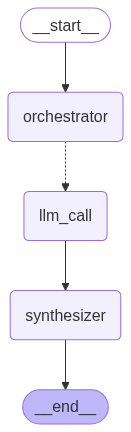

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from IPython.display import Markdown

state = {"topic":"Deep Sea Tourism"}
result = graph.invoke(state)
Markdown(result["final_report"])

Report Sections:  sections=[section(name='Introduction', description='An overview of deep-sea tourism, its growing popularity, and the unique challenges it presents.'), section(name='Ecological Impact', description='Exploring the potential effects of deep-sea tourism on fragile marine ecosystems and biodiversity.'), section(name='Technological Advancements', description='Highlighting the latest technologies enabling deep-sea exploration and their role in sustainable tourism.'), section(name='Economic Opportunities', description='Examining the economic benefits of deep-sea tourism for coastal communities and developing nations.'), section(name='Ethical Considerations', description='Discussing the ethical dilemmas associated with deep-sea tourism, such as animal welfare and environmental responsibility.'), section(name='Future Prospects', description='Looking ahead at the future of deep-sea tourism, considering its potential for growth, sustainability, and responsible exploration.')]


## Introduction

Deep-sea tourism, a relatively nascent industry, is experiencing a surge in popularity.  The allure of exploring the mysterious and largely unexplored depths of the ocean captivates adventurers and scientists alike. 

This growing interest, however, presents unique challenges.  The extreme pressure, darkness, and cold of the deep sea require specialized equipment and expertise, making deep-sea tourism inherently risky.  Furthermore, the fragile and delicate nature of deep-sea ecosystems demands responsible and sustainable practices to minimize environmental impact. 


---

## Ecological Impact

Deep-sea tourism, while offering unique experiences, presents potential risks to the delicate balance of marine ecosystems. 

Submersibles and other vessels used in deep-sea tourism can disturb sediment and create noise pollution that can disorient and stress marine life. 

The introduction of foreign materials, such as sunscreen and waste, can have harmful consequences for deep-sea organisms. 

Furthermore, direct contact between tourists and marine species, even seemingly harmless interactions, can damage sensitive habitats and disrupt natural behaviors.

The potential for invasive species introduction through tourism equipment and ballast water is also a concern. 

Mitigating these risks requires careful planning, strict regulations, and responsible visitor practices to minimize the ecological footprint of deep-sea tourism and ensure the long-term health of these vulnerable environments. 




---

## Technological Advancements

Remotely Operated Vehicles (ROVs) have revolutionized deep-sea exploration, allowing scientists and researchers to observe and interact with marine life in extreme environments without risking human lives. Equipped with high-definition cameras, manipulator arms, and various sensors, ROVs provide real-time data and stunning visuals, enhancing our understanding of the deep ocean and its inhabitants.  

Autonomous Underwater Vehicles (AUVs) offer another significant advancement, capable of navigating and collecting data independently.  These sophisticated robots can map vast areas of the seafloor, monitor water quality, and track marine species, contributing to comprehensive environmental assessments crucial for sustainable tourism planning. 

Advanced sonar technology plays a vital role in deep-sea mapping and navigation.  High-resolution sonar systems generate detailed images of the seabed, revealing underwater topography, geological features, and potential sites of interest for tourists.  

Underwater communication systems have improved significantly, enabling real-time data transfer and communication between surface vessels, ROVs, and AUVs. This enhances coordination and safety during deep-sea exploration and ensures that tourists have access to reliable and timely information. 

The development of bioluminescent sensors and biomimicry technologies offers exciting possibilities for sustainable tourism.  Bioluminescent sensors can illuminate the depths, reducing the need for harmful artificial lighting that disrupts marine life. Biomimicry-inspired designs, such as underwater habitats and transportation systems, minimize environmental impact and offer unique and immersive experiences for tourists.




---

## Economic Opportunities

Deep-sea tourism presents a significant opportunity to stimulate economic growth in coastal communities and developing nations. 

**Job Creation:** The industry can create a wide range of jobs, from tour guides and marine biologists to boat operators, maintenance staff, and hospitality workers. This can provide much-needed employment opportunities in areas with limited economic diversification.

**Revenue Generation:**  Deep-sea tourism can generate substantial revenue through ticket sales, equipment rentals, and ancillary services like accommodation, dining, and souvenirs. This revenue can be reinvested in local infrastructure, education, and healthcare.

**Diversification of Economies:**  By offering a unique and high-value tourism product, deep-sea tourism can help diversify local economies, reducing reliance on traditional industries like fishing or agriculture, which can be vulnerable to natural disasters or market fluctuations.

**Community Empowerment:**  Local communities can be actively involved in the development and operation of deep-sea tourism ventures, giving them ownership and control over their resources and economic benefits.

**Boosting Local Businesses:**  The influx of tourists can benefit local businesses, including restaurants, shops, and transportation services, leading to increased economic activity in the region.


It is crucial to note that the realization of these economic benefits depends on responsible and sustainable development practices.  Careful planning, environmental protection, and equitable distribution of profits are essential to ensure that deep-sea tourism contributes to long-term prosperity for coastal communities and developing nations.


---

## Ethical Considerations

Deep-sea tourism presents several ethical dilemmas that require careful consideration.  

**Animal Welfare:**

The potential impact of tourism on deep-sea ecosystems and their inhabitants is a major concern.  While regulations exist to minimize disturbance, the presence of vessels, submersibles, and human observers can still stress and displace marine life. 

* **Disturbance and Habitat Degradation:**  The physical presence of tourists and equipment can disrupt delicate deep-sea habitats, potentially damaging fragile ecosystems and affecting the organisms that rely on them.
* **Behavioral Change:**  Animals may alter their natural behaviors in response to human presence, such as avoiding feeding grounds or altering migration patterns. This can have cascading effects on the entire ecosystem.
* **Noise Pollution:**  The noise generated by submersibles and other equipment can travel long distances underwater, interfering with marine animal communication, navigation, and feeding behaviors.

**Environmental Responsibility:**

Deep-sea tourism also raises concerns about the environmental footprint of the industry.

* **Waste Management:**  Disposal of waste from vessels and submersibles poses a risk to deep-sea environments.  Proper waste management systems are crucial to prevent pollution.
* **Carbon Emissions:**  The transportation of tourists and equipment contributes to greenhouse gas emissions, exacerbating climate change, which already poses significant threats to deep-sea ecosystems.
* **Introduction of Invasive Species:**  Unintentional introduction of non-native species through ballast water or equipment can have devastating consequences for deep-sea biodiversity.


Balancing the potential benefits of deep-sea tourism with the ethical considerations is essential. Implementing strict regulations, promoting responsible tourism practices, and investing in research to understand the impacts are crucial steps towards ensuring the long-term sustainability of these fragile ecosystems.  


---

## Future Prospects

Deep-sea tourism holds immense potential for growth, driven by increasing public interest in exploring the unknown and the allure of unique marine experiences. Technological advancements, such as improved submersibles and underwater robotics, will further enhance accessibility and safety, making exploration more feasible and appealing.  

However, this burgeoning industry faces significant challenges related to sustainability and responsible exploration. 

* **Environmental Impact:** Minimizing disturbance to fragile deep-sea ecosystems is crucial. Careful planning, strict regulations, and the adoption of eco-friendly practices, such as minimizing noise pollution and waste generation, are essential to ensure the long-term health of these environments. 
* **Conservation:** Balancing tourism with the need for conservation requires careful management. Establishing protected areas, monitoring visitor impact, and supporting research initiatives will be vital for safeguarding deep-sea biodiversity.
* **Ethical Considerations:**  Ensuring the ethical treatment of marine life and the preservation of cultural heritage sites are paramount.  

Responsible tourism practices, including education and awareness campaigns, will be key to fostering a sense of stewardship and promoting sustainable exploration of the deep sea. By addressing these challenges proactively, deep-sea tourism can evolve into a responsible and sustainable industry that brings both economic benefits and scientific discoveries while preserving the wonders of the deep ocean for future generations. 
